<a href="https://colab.research.google.com/github/GiulianoFassano/prueba-DT/blob/master/DS_FassanoGiuliano_P3_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [111]:
!pip install feature_engine
!pip install category_encoders
!pip install fitter
!pip install scikit-learn

In [112]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate
import datetime
import pystan
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

# Gráficos
# ==============================================================================
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#importo las librerias de pipeline
import feature_engine
import category_encoders as ce
from imblearn.pipeline import Pipeline
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer 
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
from feature_engine.encoding import RareLabelEncoder, MeanEncoder
from sklearn.compose import ColumnTransformer

##from skopt.space import Real, Integer
##from skopt.utils import use_named_args
##from skopt import gp_minimize
##from skopt.plots import plot_convergence

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

# Librería para medir tiempos
import time

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Codigo para poder imprimir multiples outputs en una misma línea
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [113]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/gdrive'
/content


In [114]:
data_2020 = pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 3/flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 3/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 3/flujo-vehicular-2018.csv', sep =',')

In [115]:
#eliminamos columnas extras del data2020.
data_2020 = data_2020 [["periodo", "fecha", "hora_inicio", "hora_fin", "dia", "estacion", "sentido", "tipo_vehiculo", "forma_pago", "cantidad_pasos"]]

In [116]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   hora_inicio     float64
 3   hora_fin        float64
 4   dia             object 
 5   estacion        object 
 6   sentido         object 
 7   tipo_vehiculo   object 
 8   forma_pago      object 
 9   cantidad_pasos  float64
dtypes: float64(4), object(6)
memory usage: 193.3+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2020.0000,2020-01-01 00:00:00,0.0000,1.0000,Miércoles,ALBERDI,Centro,Auto,Efectivo,24.0000
1,2020.0000,2020-01-01 00:00:00,0.0000,1.0000,Miércoles,ALBERDI,Provincia,Auto,Efectivo,80.0000
2,2020.0000,2020-01-01 00:00:00,0.0000,1.0000,Miércoles,ALBERDI,Provincia,Auto,Rec.Deuda,1.0000
3,2020.0000,2020-01-01 00:00:00,0.0000,1.0000,Miércoles,ALBERDI,Centro,Auto,Rec.Deuda,1.0000
4,2020.0000,2020-01-01 00:00:00,0.0000,1.0000,Miércoles,ALBERDI,Provincia,Auto,Rec.Deuda,1.0000


In [117]:
data_2020[["periodo", "hora_inicio", "hora_fin", "cantidad_pasos"]] = data_2020[["periodo", "hora_inicio", "hora_fin", "cantidad_pasos"]].astype(int)

In [118]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   periodo         int64 
 1   fecha           object
 2   hora_inicio     int64 
 3   hora_fin        int64 
 4   dia             object
 5   estacion        object
 6   sentido         object
 7   tipo_vehiculo   object
 8   forma_pago      object
 9   cantidad_pasos  int64 
dtypes: int64(4), object(6)
memory usage: 193.3+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2020,2020-01-01 00:00:00,0,1,Miércoles,ALBERDI,Centro,Auto,Efectivo,24
1,2020,2020-01-01 00:00:00,0,1,Miércoles,ALBERDI,Provincia,Auto,Efectivo,80
2,2020,2020-01-01 00:00:00,0,1,Miércoles,ALBERDI,Provincia,Auto,Rec.Deuda,1
3,2020,2020-01-01 00:00:00,0,1,Miércoles,ALBERDI,Centro,Auto,Rec.Deuda,1
4,2020,2020-01-01 00:00:00,0,1,Miércoles,ALBERDI,Provincia,Auto,Rec.Deuda,1


In [119]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [120]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [121]:
print(data_2020['estacion'].unique())
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [122]:
print(data_2020['sentido'].unique())
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [123]:
print(data_2020['tipo_vehiculo'].unique())
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())

['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago Doble Auto'
 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago doble Moto'
 'Pesados 2 Ejes' 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes'
 'Pesados 6 Ejes']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [124]:
print(data_2020['forma_pago'].unique())
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())

['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP' 'Mercado Pago']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']


In [125]:
#Debemos unir criterios de las bases de datos - 
#Se realiza por lógica la división

data_2020["estacion"] = data_2020["estacion"].map({"ILLIA":"Illia"} 
                                                  )

data_2020["forma_pago"] = data_2020["forma_pago"].map({"Efectivo":"EFECTIVO"} 
                                                  )

data_2020["tipo_vehiculo"] = data_2020["tipo_vehiculo"].map({"Auto":"Liviano",
                                                             "Auto con trailer":"Liviano",
                                                             "Moto":"Liviano",
                                                             "N/D":"Liviano",
                                                             "Pago Doble Auto":"Liviano",
                                                             "Pago Doble Auto con trailer / Pesado 2 Ejes":"Pesado",
                                                             "Pago doble Moto":"Liviano",
                                                             'Pesados 2 Ejes':"Pesado",
                                                             'Pesados 3 Ejes':"Pesado",
                                                             'Pesados 4 Ejes':"Pesado",
                                                             'Pesados 5 Ejes':"Pesado",
                                                             'Pesados 6 Ejes':"Pesado"}, 
                                                  na_action=None)

In [126]:
print(data_2020['estacion'].unique())
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())

[nan 'Illia']
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [127]:
print(data_2020['sentido'].unique())
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [128]:
print(data_2020['tipo_vehiculo'].unique())
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [129]:
print(data_2020['forma_pago'].unique())
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())

['EFECTIVO' nan]
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']


##### Podemos decir entonces que los años 2018, 2019 y 2020 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [130]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset2020 = pd.concat([data_2020, data_2019, data_2018])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset2020.estacion=='Illia', dataset2020.forma_pago == 'EFECTIVO')
dataset2020 = dataset2020[mask]

#Quitamos las columnas que no vamos a utilizar
dataset2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset2020.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
52,2020-01-01 00:00:00,1,Miércoles,Centro,Liviano,326
53,2020-01-01 00:00:00,1,Miércoles,Provincia,Liviano,319
134,2020-01-01 00:00:00,2,Miércoles,Centro,Liviano,199
135,2020-01-01 00:00:00,2,Miércoles,Provincia,Liviano,180
202,2020-01-01 00:00:00,3,Miércoles,Centro,Liviano,114


In [131]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset2020['fecha2'] = pd.to_datetime(dataset2020.fecha) + pd.to_timedelta(dataset2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset2020.drop(columns=['fecha','hora_fin'], inplace = True)

dataset2020.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
52,Miércoles,Centro,Liviano,326,2020-01-01 01:00:00
53,Miércoles,Provincia,Liviano,319,2020-01-01 01:00:00
134,Miércoles,Centro,Liviano,199,2020-01-01 02:00:00
135,Miércoles,Provincia,Liviano,180,2020-01-01 02:00:00
202,Miércoles,Centro,Liviano,114,2020-01-01 03:00:00


In [132]:
#Corregimos el nombre de fecha2 a fecha
dataset2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset2020.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
52,Miércoles,Centro,Liviano,326,2020-01-01 01:00:00
53,Miércoles,Provincia,Liviano,319,2020-01-01 01:00:00
134,Miércoles,Centro,Liviano,199,2020-01-01 02:00:00
135,Miércoles,Provincia,Liviano,180,2020-01-01 02:00:00
202,Miércoles,Centro,Liviano,114,2020-01-01 03:00:00


In [133]:
#Reordenamos el dataset por fecha
dataset2020.sort_values('fecha', inplace = True)
dataset2020.reset_index(drop=True, inplace = True)
dataset2020

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Lunes,Provincia,Liviano,14,2018-01-01 00:00:00
1,Lunes,Centro,Pesado,2,2018-01-01 00:00:00
2,Lunes,Centro,Pesado,1,2018-01-01 00:00:00
3,Lunes,Centro,Pesado,8,2018-01-01 00:00:00
4,Lunes,Centro,Pesado,2,2018-01-01 00:00:00
...,...,...,...,...,...
187008,Jueves,Centro,Liviano,1,2020-12-31 20:00:00
187009,Jueves,Centro,Liviano,5,2020-12-31 21:00:00
187010,Jueves,Provincia,Liviano,1,2020-12-31 21:00:00
187011,Jueves,Provincia,Liviano,106,2020-12-31 21:00:00


<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, 'Tiempo')

Text(0, 0.5, 'Cantidad de autos, por hora')

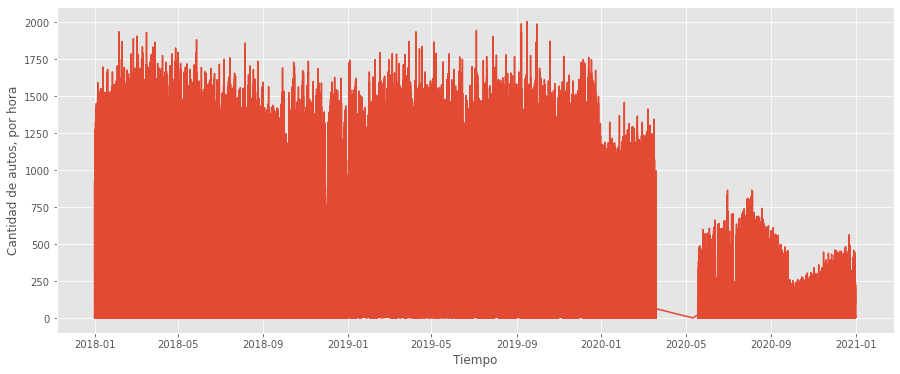

In [135]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset2020.fecha, dataset2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [136]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario2020 = dataset2020.resample('D', on = 'fecha').sum()
print(diario2020.shape)
diario2020.head()

(1096, 1)


,cantidad_pasos
fecha,
2018-01-01,30735
2018-01-02,47130
2018-01-03,48162
2018-01-04,47953
2018-01-05,49505


<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, 'Tiempo')

Text(0, 0.5, 'Cantidad de autos, por dia')

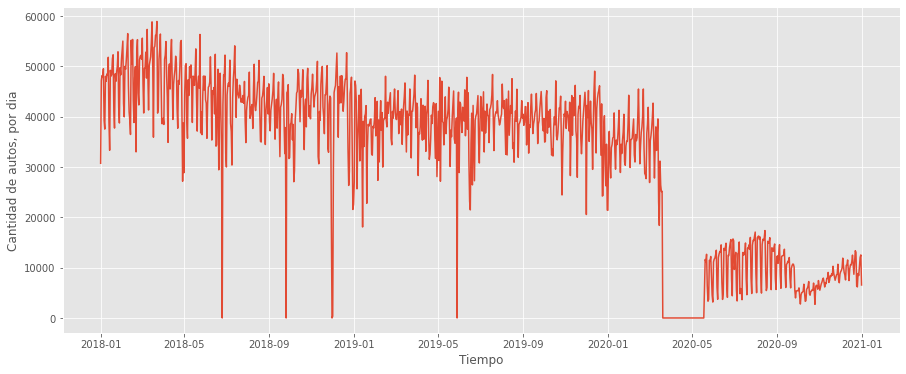

In [137]:
plt.figure(figsize = (15,6))
plt.plot(diario2020.index, diario2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [138]:
diario2020.reset_index(drop = False, inplace = True)
diario2020.head()

,fecha,cantidad_pasos
0,2018-01-01,30735
1,2018-01-02,47130
2,2018-01-03,48162
3,2018-01-04,47953
4,2018-01-05,49505


1. Lo que se hizo fue buscar utilizar datos más actualizados, pero viendo cómo afectó la pandemia a este sector (como a muchos otros) se volverá a la información 2017 , 2018 y 2019 para realizar el análisis y ver si se puede realizar un análisis correcto en base a dichos años.

2. igualmente, ya sabemos que realizar el análisis, al tener los datos del 2020 y haberse producido una pandemia, no dará un resultado correcto. Obviamente un modelo predictivo no puede predecir una pandemia mundial.

3. Deberíamos utilizar datos actualizados de la base de datos 2020 y 2021 para ver como evolucionará en el año 2022


In [139]:
data_2019 = pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 3/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 3/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/content/gdrive/MyDrive/ACAMICA - DS/Proyecto 3/flujo-vehicular-2017.csv', sep =',')

In [140]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [141]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [142]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [143]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [144]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [145]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [146]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


Volvemos a seleccionar la estación **Illia** y la forma de pago **Efectivo**


In [147]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

#dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [148]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#dataset.head()

In [149]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#dataset.head()

In [150]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
#dataset

<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, 'Tiempo')

Text(0, 0.5, 'Cantidad de autos, por hora')

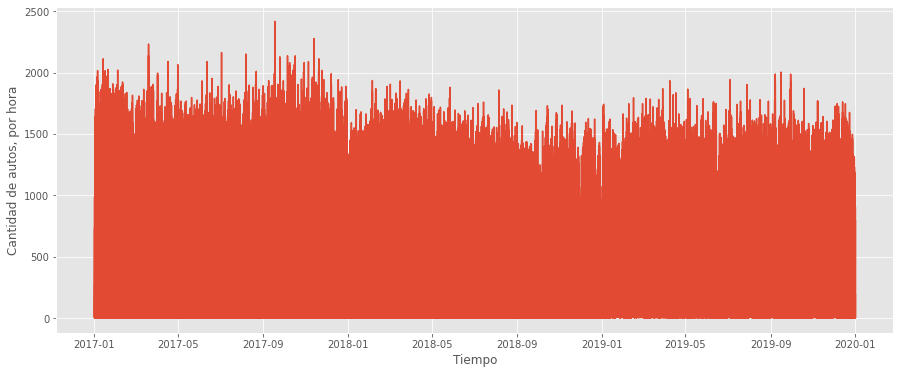

In [151]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [152]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
#diario.head()

(1095, 1)


<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, 'Tiempo')

Text(0, 0.5, 'Cantidad de autos, por dia')

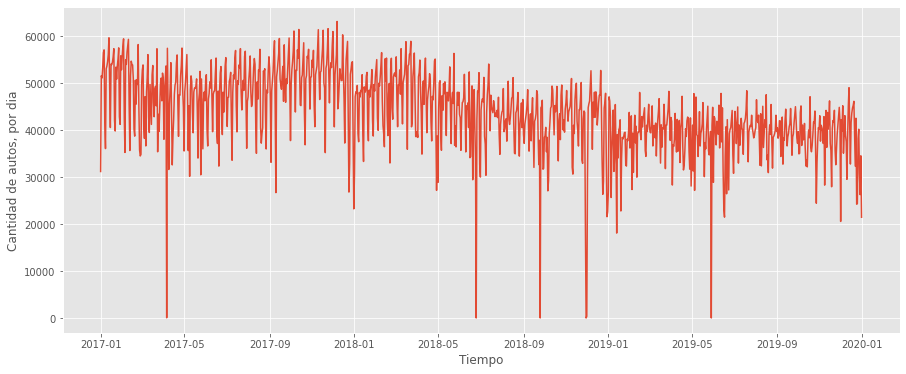

In [153]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

# AED

In [154]:
# cambio el nombre solo por comodidad
df = dataset.copy()
del dataset

datasets:
- df (contiene toda la info, hasta discriminada por hora)
- diario

# MANEJO DE OUTLIERS

In [155]:
diario[diario.cantidad_pasos < 15000]

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Paros:
- 06/04/17
- 25/06/18
- 25/09/18
- 29/05/19

G20:
- 30/11/18
- 01/12/18

Voy a imputar el paso promedio segun el dia de la semana al que corresponde el valor extremo

In [156]:
diario.reset_index(drop = False, inplace = True)
diario.head()

,fecha,cantidad_pasos
0,2017-01-01,31183
1,2017-01-02,51568
2,2017-01-03,51093
3,2017-01-04,53332
4,2017-01-05,56486


In [157]:
diario['dia'] = diario['fecha'].dt.dayofweek

In [158]:
def conversor_dia(dia):
    if dia == 0:
        return 'lunes'
    if dia == 1:
        return 'martes'
    if dia == 2:
        return 'miercoles'
    if dia == 3:
        return 'jueves'
    if dia == 4:
        return 'viernes'
    if dia == 5:
        return 'sabado'
    if dia == 6:
        return 'domingo'
diario['dia'] = diario['dia'].apply(lambda dia: conversor_dia(dia))
diario.head()

,fecha,cantidad_pasos,dia
0,2017-01-01,31183,domingo
1,2017-01-02,51568,lunes
2,2017-01-03,51093,martes
3,2017-01-04,53332,miercoles
4,2017-01-05,56486,jueves


In [159]:
promedio_por_dia = (diario.groupby(by = 'dia').mean()).round()
promedio_por_dia

,cantidad_pasos
dia,
domingo,36891.0000
jueves,46809.0000
lunes,42620.0000
martes,43730.0000
miercoles,45676.0000
sabado,41293.0000
viernes,49021.0000


Observacion

Los fines de semana hay una menor circulacion (principalmente el domingo que se corresponde como el dia de descanso de la mayoria de las profesiones y a que no hay clases).

In [160]:
outliers = diario[diario.cantidad_pasos < 15000]
outliers

,fecha,cantidad_pasos,dia
95,2017-04-06,40,jueves
540,2018-06-25,0,lunes
632,2018-09-25,0,martes
698,2018-11-30,0,viernes
699,2018-12-01,350,sabado
878,2019-05-29,0,miercoles


In [161]:
# Agrego columna promedio_por_dia para poder hacer el for
outliers = pd.merge(outliers, promedio_por_dia, how = 'left', left_on = 'dia', right_index = True)
outliers.rename(columns = {'cantidad_pasos_y':'promedio_por_dia'}, inplace = True)
outliers

,fecha,cantidad_pasos_x,dia,promedio_por_dia
95,2017-04-06,40,jueves,46809.0000
540,2018-06-25,0,lunes,42620.0000
632,2018-09-25,0,martes,43730.0000
698,2018-11-30,0,viernes,49021.0000
699,2018-12-01,350,sabado,41293.0000
878,2019-05-29,0,miercoles,45676.0000


In [162]:
for x in outliers['fecha']:    
    diario['cantidad_pasos'].values[diario['fecha'] == x] = outliers[outliers['fecha'] == x]['promedio_por_dia']

print((diario.cantidad_pasos < 15000).sum())  

0


# NULLS

In [ ]:
pd.isna(df).sum()

No hay nulos, por lo tanto no se realizan ajustes

In [ ]:
diario

TENDENCIA

In [163]:
tendencia = diario['cantidad_pasos'].rolling(window = 4, center = True).mean()
tendencia = pd.DataFrame(tendencia)
tendencia.head()

,cantidad_pasos
0,NaN
1,NaN
2,46794.0000
3,53119.7500
4,54498.0000


<Figure size 1800x432 with 0 Axes>

Text(0.5, 0, 'Tiempo')

Text(0, 0.5, 'Cantidad de autos, por dia')

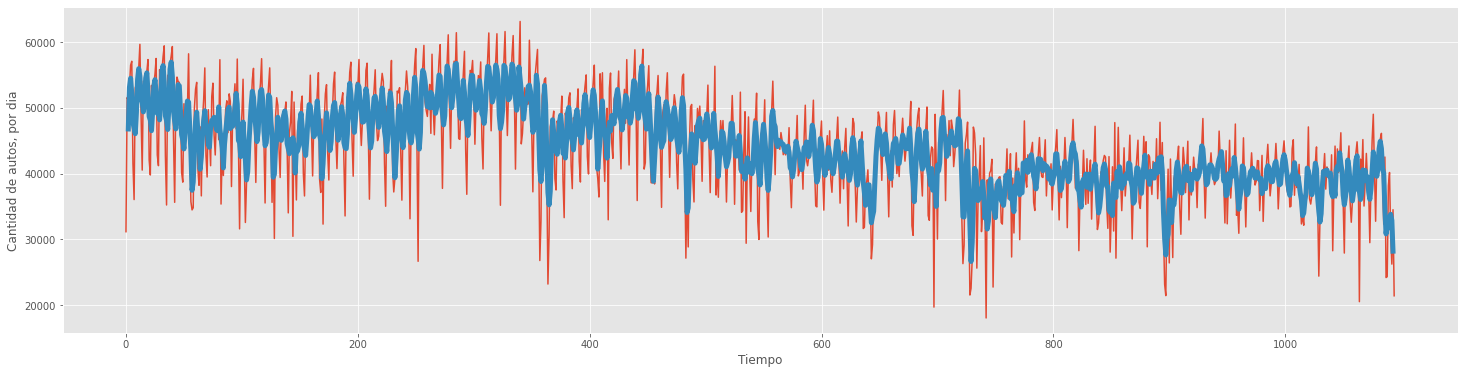

In [164]:
plt.figure(figsize = (25,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.plot(tendencia.index, tendencia.cantidad_pasos, lw = 5)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

<Figure size 1080x432 with 0 Axes>

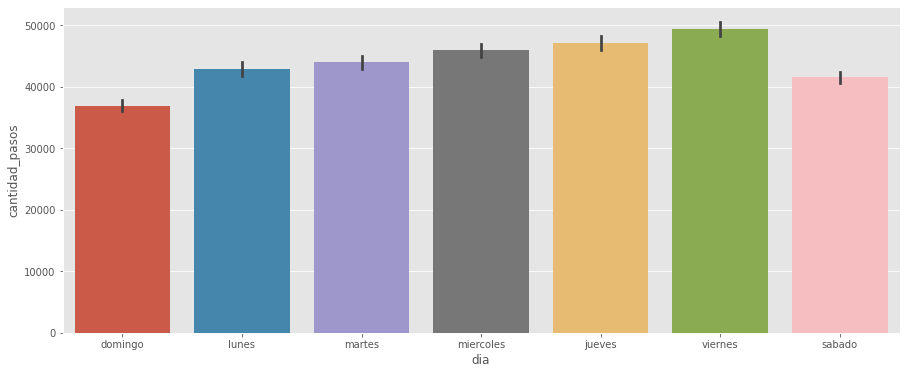

In [165]:
plt.figure(figsize = (15,6))

sns.barplot(x = 'dia', y = 'cantidad_pasos', data = diario)

plt.show()

### La tendencia se observa negativa.

Es logico pensar que dicha tendencia se puede deber a:

1- El medio de pago en efectivo tiene tendencia a eliminarse y por lo tanto tiene correlación negativa a futuro respecto a la cantidad de autos que pasan.
Se debe tanto a promociones de los otros medios como a la rapidez de paso.

2- La crisis económica puede hacer que las personas utilicen medios alternativos de transporte (trenes, autobuses, ir varios en un sólo auto, etc.) lo que produce una disminución en la cantidad de pases.

3- El valor de los automóviles aumenta, como así los impuestos de los mismos y la dificultad de comprar, lo que hace que la cantidad de automóviles aumente en menor proporción que la cantidad de personas.

4- la tendencia al "homeoffice"

### Por otro lado, se observa que los días en los que menos cantidad de pasos hay, es los fin de semana, cuando la gente trabaja menos y cuando no hay colegio

#En los siguientes análisis, deseo observar si, al igual que se observa al analizar los días (donde se observa que los fin de semanas hay menor tránsito), pasa lo mismo semana a semana y mes a mes.

In [166]:
semanal = diario.resample(rule = "W", on = 'fecha').sum()

# eliminamos primera y ultima fila (es un dia, no una semana)
semanal.drop(index = [semanal.index[0],semanal.index[157]], inplace = True)
semanal.head()

,cantidad_pasos
fecha,
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581
2017-02-05,359401


In [167]:
tendencia_semanal = semanal['cantidad_pasos'].rolling(window = 4, center = True).mean()
tendencia_semanal = pd.DataFrame(tendencia_semanal)
tendencia_semanal.head()

,cantidad_pasos
fecha,
2017-01-08,NaN
2017-01-15,NaN
2017-01-22,356355.2500
2017-01-29,359402.5000
2017-02-05,358742.7500


<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, 'Tiempo')

Text(0, 0.5, 'Cantidad de autos, por semana')

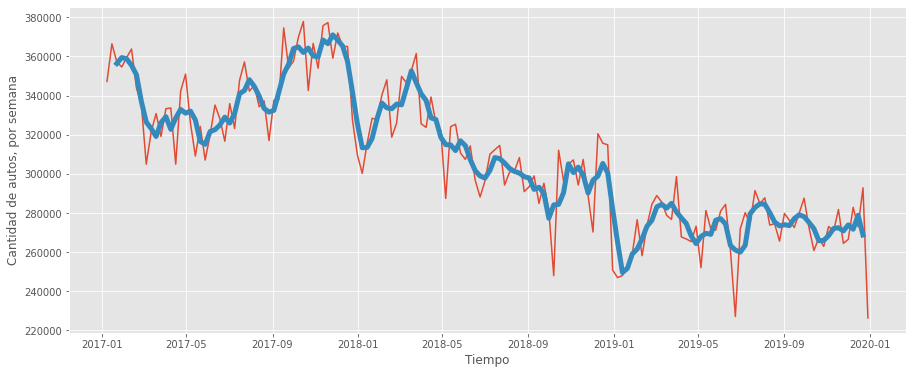

In [168]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.plot(tendencia_semanal.index, tendencia_semanal.cantidad_pasos, lw = 5)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

In [169]:
mensual = diario.resample(rule = 'M', on = 'fecha').sum()

mensual.reset_index(drop = False, inplace = True)

mensual['mes'] = mensual.fecha.dt.month
mensual.head()


,fecha,cantidad_pasos,mes
0,2017-01-31,1565260,1
1,2017-02-28,1363113,2
2,2017-03-31,1451214,3
3,2017-04-30,1420754,4
4,2017-05-31,1407136,5


<Figure size 1080x432 with 0 Axes>

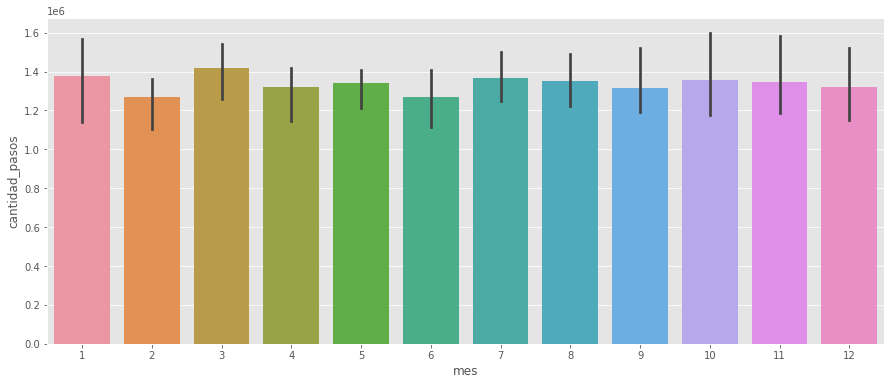

In [170]:
plt.figure(figsize = (15,6))

sns.barplot(x = 'mes', y = 'cantidad_pasos', data = mensual)

plt.show()

Observando los datos de manera semanal, se observa con mayor claridad la tendencia negativa, mientras que observando mensualmente, podemos concluir que los meses de menor pases es febrero, junio y diciembre. 

Las conclusiones que podría sacar y que deberían validarse (teniendo en cuenta otros medios de pago y en otro trabajo) son:

- Dichos meses se correlacionan con las vacaciones
- Que enero no sea bajo, seguramente sea porque se reemplazan pases por gente que no trabaja con el turismo.


Para poder avanzar con estas hipotesis, deberíamos analizar la circulación por hora, ya que podríamos obtener si realmente disminuye en horarios escolares y de ingreso al trabajo.

In [171]:
df['año'] = df.fecha.dt.year
df['mes'] = df.fecha.dt.month
df['numero_dia'] = df.fecha.dt.day
df['hora'] = df.fecha.dt.hour

df.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha,año,mes,numero_dia,hora
0,Domingo,Provincia,Pesado,1,2017-01-01,2017,1,1,0
1,Domingo,Provincia,Liviano,9,2017-01-01,2017,1,1,0
2,Domingo,Provincia,Liviano,644,2017-01-01,2017,1,1,0
3,Domingo,Provincia,Pesado,6,2017-01-01,2017,1,1,0
4,Domingo,Provincia,Pesado,1,2017-01-01,2017,1,1,0


In [172]:
hora = (df[['cantidad_pasos','hora']].groupby(by = 'hora').mean()).round()
hora.head()

,cantidad_pasos
hora,
0,114.0000
1,99.0000
2,71.0000
3,52.0000
4,41.0000


<Figure size 1080x432 with 0 Axes>

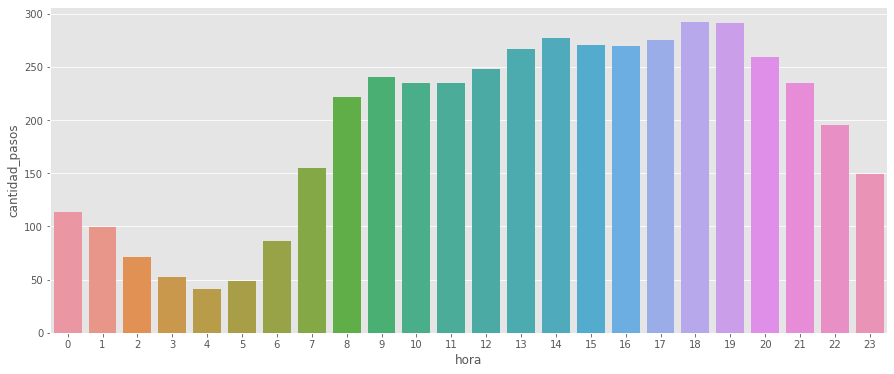

In [173]:
plt.figure(figsize = (15,6))

sns.barplot(x = hora.index ,y = 'cantidad_pasos', data = hora)

plt.show()

Al analizar la circulacion se puede observar la disminucion a partir del anochecer, y los picos en las horas asociadas tanto a la jornada laboral cotidiana (de 9 a 18 hs) cómo
a la jornada de clases (8 a 13:30hs y de 14 a 18 hs)

Vamos a discriminar por tipo de vehiculo

Análisamos ahora los tipos de vehículos que pasan, para descartar que influya en el análisis

In [174]:
hora_tipo_vehiculo = df.groupby(by = ['hora','tipo_vehiculo']).mean()
hora_tipo_vehiculo.reset_index(drop = False, inplace = True)
hora_tipo_vehiculo.head()

,hora,tipo_vehiculo,cantidad_pasos,año,mes,numero_dia
0,0,Liviano,284.4805,2017.7982,6.5032,15.6569
1,0,Pesado,4.6979,2017.6702,6.3875,15.6899
2,1,Liviano,237.4445,2017.7980,6.5072,15.7306
3,1,Pesado,4.4245,2017.7010,6.4410,15.7196
4,2,Liviano,164.5217,2017.7996,6.5123,15.7332


In [175]:
hora_pesado = df[df.tipo_vehiculo == 'Pesado']
hora_pesado = hora_pesado.groupby(by = 'hora').mean()


hora_liviano = df[df.tipo_vehiculo == 'Liviano']
hora_liviano = hora_liviano.groupby(by = 'hora').mean()


<Figure size 1080x432 with 0 Axes>

Text(0.5, 1.0, 'Circulacion diaria Livianos')

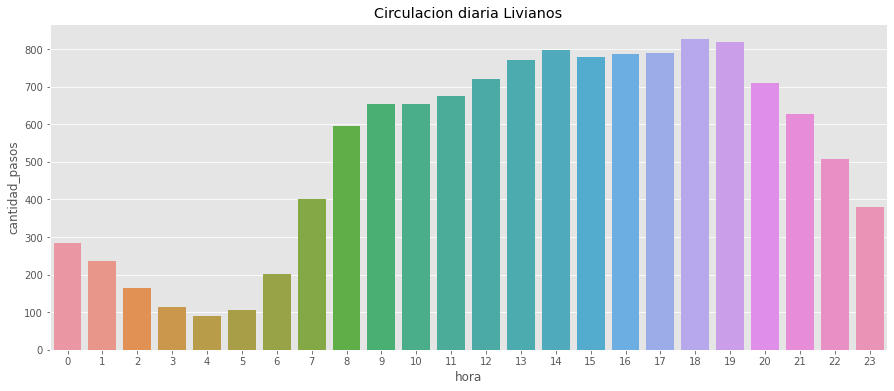

In [176]:
plt.figure(figsize = (15,6))

sns.barplot(x = hora_liviano.index, y = 'cantidad_pasos', data = hora_liviano)
plt.title("Circulacion diaria Livianos")
plt.show()

<Figure size 1080x432 with 0 Axes>

Text(0.5, 1.0, 'Circulacion diaria Pesados')

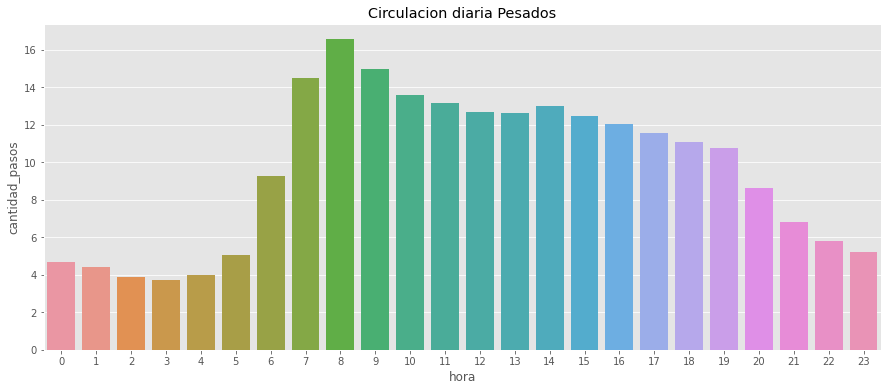

In [177]:
plt.figure(figsize = (15,6))

sns.barplot(x = hora_pesado.index, y = 'cantidad_pasos', data = hora_pesado)
plt.title("Circulacion diaria Pesados")
plt.show()

En base a esta nueva información, averigüe los horarios comerciales e industriales de la zona, como así los horarios de los colegios.

El horario comercial es de 9 a 20 hs, teniendo en cuenta la jornada laboral de 8 horas y lor horarios cortados, es entendible lo de los autos livianos.

Por otro lado, el transporte pesado siempre busca evitar los horarios picos, lo que se traduce en la diferencia con los livianos.

#### Vamos a analizar los sentidos

In [178]:
hora_sentido = df.groupby(by = ['hora','sentido']).mean()
hora_sentido.reset_index(drop = False, inplace = True)
hora_sentido.head()

,hora,sentido,cantidad_pasos,año,mes,numero_dia
0,0,Centro,106.4315,2017.6955,6.3485,15.6120
1,0,Provincia,122.9841,2017.7484,6.5281,15.7505
2,1,Centro,86.2550,2017.7089,6.3940,15.7051
3,1,Provincia,113.7997,2017.7772,6.5544,15.7462
4,2,Centro,62.5481,2017.7174,6.3902,15.8370


<Figure size 1080x432 with 0 Axes>

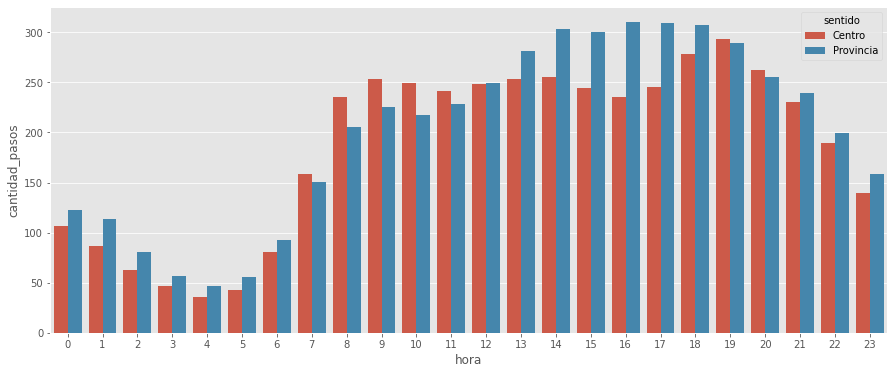

In [179]:
plt.figure(figsize = (15,6))

sns.barplot(x = 'hora' , y = 'cantidad_pasos', data = hora_sentido, hue = 'sentido')

plt.show() 

El resultado es bastante obvio, viajan hacia el centro para trabajar en horarios matutinos, mientras que a la tarde vuelven a sus hogares. Hay más gente que vive a las afueras y que trabaja en el centro.

In [180]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib

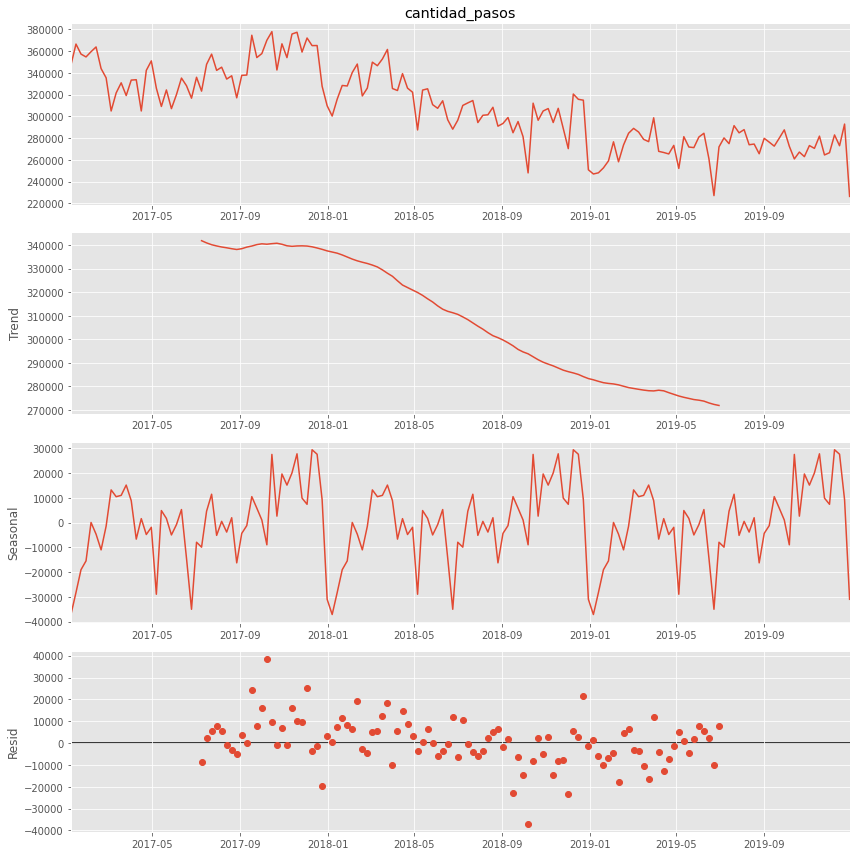

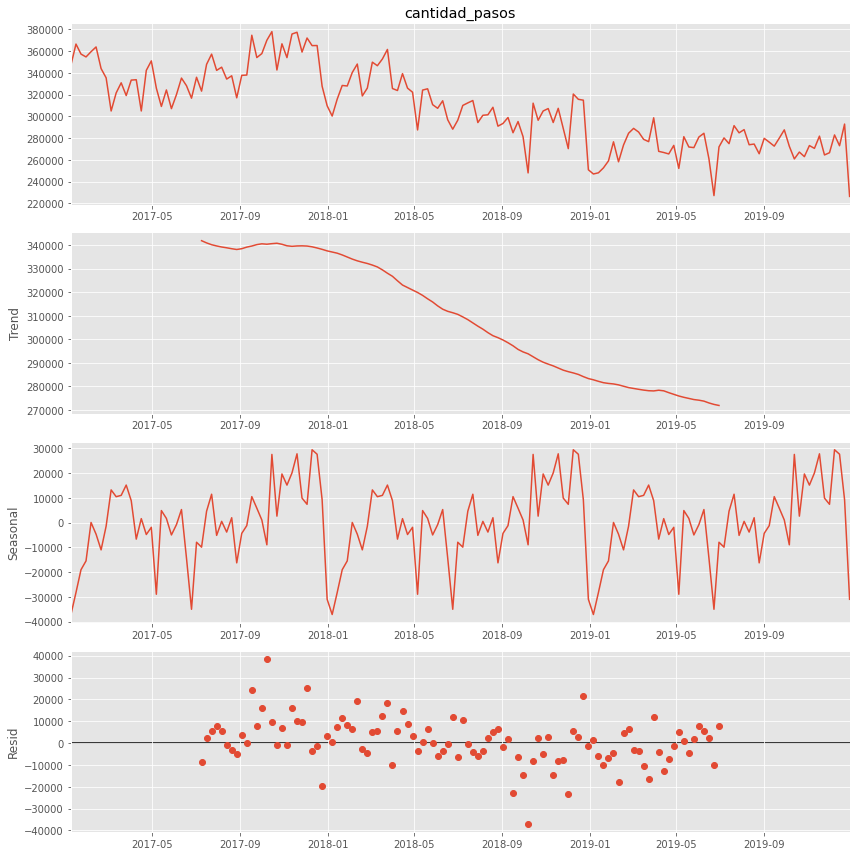

In [181]:
result = seasonal_decompose(semanal.cantidad_pasos, model='additive')

matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

Se sigue observando la tendencia negativa, seguimos suponiendo los supuestos que se vienen planteando anteriormente y que se deberían ir analizando particularmente (observando otros medios de pago, teniendo en cuenta el homeoffice, etc.)

## AutoCorrelación

In [182]:
from statsmodels.tsa.stattools import acf

In [183]:
nlags = 30
autocorr = acf(diario.cantidad_pasos, nlags = nlags, fft=False)

<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, 'lag')

Text(0, 0.5, 'coeficiente')

Text(0.5, 1.0, 'Autocorrelacion')

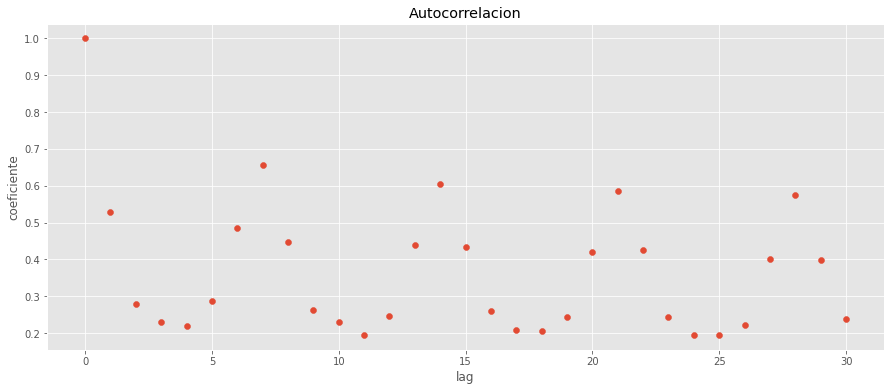

In [184]:
plt.figure(figsize = (15,6))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')
plt.ylabel('coeficiente')
plt.title('Autocorrelacion')
plt.show()

Al analizar la autocorrelacion, utilizo un lag de 30, ya que un mes tiene 30 dias donde tienen 4 semanas y 7 dias, lo que hace que logicamente estén correlacionados.

# Modelo Predictivo

In [185]:
diario

,fecha,cantidad_pasos,dia
0,2017-01-01,31183,domingo
1,2017-01-02,51568,lunes
2,2017-01-03,51093,martes
3,2017-01-04,53332,miercoles
4,2017-01-05,56486,jueves
...,...,...,...
1090,2019-12-27,40182,viernes
1091,2019-12-28,30681,sabado
1092,2019-12-29,26259,domingo
1093,2019-12-30,34523,lunes


In [186]:
diario2020

,fecha,cantidad_pasos
0,2018-01-01,30735
1,2018-01-02,47130
2,2018-01-03,48162
3,2018-01-04,47953
4,2018-01-05,49505
...,...,...
1091,2020-12-27,8434
1092,2020-12-28,10311
1093,2020-12-29,12036
1094,2020-12-30,12527


In [187]:
#Agregamos una columna de fecha convertida para poder hacer el modelo
diario['fecha_numeros'] = diario.fecha.map(datetime.datetime.toordinal)
diario.head()

,fecha,cantidad_pasos,dia,fecha_numeros
0,2017-01-01,31183,domingo,736330
1,2017-01-02,51568,lunes,736331
2,2017-01-03,51093,martes,736332
3,2017-01-04,53332,miercoles,736333
4,2017-01-05,56486,jueves,736334


In [189]:
#Agregamos una columna de fecha convertida para poder hacer el modelo
diario2020['fecha_numeros'] = diario2020.fecha.map(datetime.datetime.toordinal)
diario2020.head()

,fecha,cantidad_pasos,fecha_numeros
0,2018-01-01,30735,736695
1,2018-01-02,47130,736696
2,2018-01-03,48162,736697
3,2018-01-04,47953,736698
4,2018-01-05,49505,736699


Como tengo el dataset 2020, vamos a predecir el primer trimestre del 2020

In [190]:
split = '2019-12-31'
train = diario[diario.fecha <= split]
test = diario2020[diario2020.fecha > split]

X_train = train[['fecha_numeros']]
y_train = train[['cantidad_pasos']]

X_test = test[['fecha_numeros']]
y_test = test[['cantidad_pasos']]

In [191]:
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)

LinearRegression()

In [192]:
split = '2019-12-31'
diario2020 = diario2020[diario2020.fecha > split]

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Cantidad de Pasos')

Text(0.5, 1.0, 'Modelo de regresion lineal')

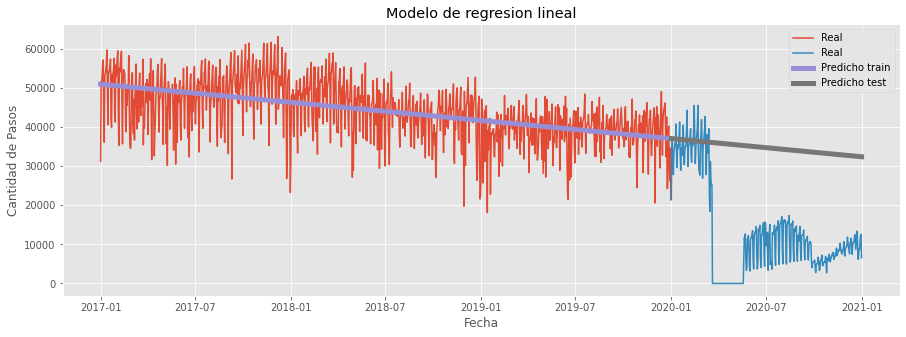

In [193]:
plt.figure(figsize = (15,5))

plt.plot(diario.fecha, diario.cantidad_pasos, label = 'Real')
plt.plot(diario2020.fecha, diario2020.cantidad_pasos, label = 'Real')
plt.plot(train.fecha, reg_lin.predict(X_train), label = 'Predicho train', lw = '5')
plt.plot(test.fecha, reg_lin.predict(X_test), label = 'Predicho test', lw = '5')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.title('Modelo de regresion lineal')
plt.legend()
plt.show()

A simple vista, se puede observar que el error de prediccion seria muy grande. Aunque fue muy util hacer dicha representancion ya que enfatiza en la negatividad de la tendencia. Sobre todo por lo que es la pandemia, pero antes de ella también.

In [194]:
y_pred = reg_lin.predict(X_test)

rmse_lineal = np.sqrt(mean_squared_error(y_test, y_pred)).round()
rmse_lineal

24260.0

Se corrobora lo que se ve visualmente.

# Se realiza el análisis mediante PROPHET

Antes que nada, la librería no pide que cambiemos los nombres para poder predecir.

In [195]:
train = train[['fecha','cantidad_pasos']]
train.rename(columns = {'fecha':'ds','cantidad_pasos':'y'}, inplace = True)

test = test[['fecha','cantidad_pasos']]
test.rename(columns = {'fecha':'ds','cantidad_pasos':'y'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [196]:
m_prophet = Prophet(daily_seasonality=True)
m_prophet.fit(train)

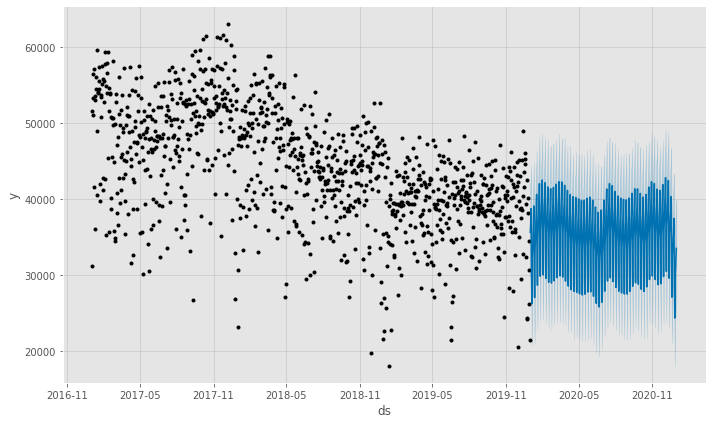

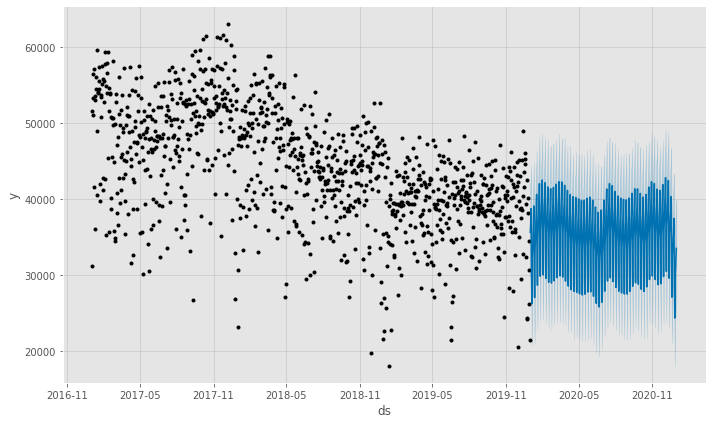

In [197]:
prediccion = m_prophet.predict(test)
m_prophet.plot(prediccion)

In [198]:
rmse_prophet = np.sqrt(mean_squared_error(test.y, prediccion.yhat)).round()
rmse_prophet

25101.0

El error de este modelo es superior al modelo anterior.

Realizo una optimización de parámetros utilizando el ONE-STEP para ver si mejora.


In [199]:
cantidad_pasos_train = diario.cantidad_pasos
look_back = 30 # usamos 1 mes de datos para predecir el valor siguiente

In [200]:
cantidad_pasos_test = diario2020.cantidad_pasos
look_back = 30 # usamos 1 mes de datos para predecir el valor siguiente

In [201]:
N_train = cantidad_pasos_train.shape[0]    
X_train = np.zeros((N_train - look_back - 1,look_back))
y_train = np.zeros(N_train - look_back - 1)

# Lleno con los respectivos valores
for i in range(X_train.shape[0]):
    X_train[i,:] = cantidad_pasos_train.iloc[i:i+look_back]
    y_train[i] = cantidad_pasos_train.iloc[i+look_back]
    
print(X_train.shape, y_train.shape)

(1064, 30) (1064,)


In [202]:
N_test = cantidad_pasos_test.shape[0]    
X_test = np.zeros((N_test - look_back - 1,look_back))
y_test = np.zeros(N_test - look_back - 1)

# Lleno con los respectivos valores
for i in range(X_test.shape[0]):
    X_test[i,:] = cantidad_pasos_test.iloc[i:i+look_back]
    y_test[i] = cantidad_pasos_test.iloc[i+look_back]
    
print(X_test.shape, y_test.shape)

(335, 30) (335,)


In [203]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4)
random_forest.fit(X_train, y_train)

RandomForestRegressor(n_jobs=4, random_state=42)

In [204]:
y_test_pred = random_forest.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)).round()
rmse

22150.0

Disminuyó el error (RMSE) del test, aunque sigue siendo alto.
Se intentará optimizar ahora los hiperparámetros mediante RandomForest

In [205]:
random_forest = RandomForestRegressor()

param_dist = {'n_estimators': [50, 100, 200],
             'max_features': np.arange(2,7),
             'n_jobs' : np.arange(3,6)}

model_random = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                  n_iter = 30, random_state = 42, cv=5)

model_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'max_features': array([2, 3, 4, 5, 6]),
                                        'n_estimators': [50, 100, 200],
                                        'n_jobs': array([3, 4, 5])},
                   random_state=42)

In [206]:
print("Mejores parametros: "+str(model_random.best_params_))

Mejores parametros: {'n_jobs': 4, 'n_estimators': 200, 'max_features': 6}


In [207]:
y_train_pred = model_random.predict(X_train)
y_test_pred = model_random.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round()
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round()

print('RMSE de train es: ', RMSE_train)
print('RMSE de test es: ', RMSE_test)

RMSE de train es:  1759.0
RMSE de test es:  23740.0


Ahora procedemos a graficar este modelo con los mejores parámetros e hiperparámetros obtenidos

In [208]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
length_total = N_train + N_test + look_back

In [210]:
#Unimos datasets, para graficar
diariografico = pd.concat([diario, diario2020])


<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Cantidad de pasos')

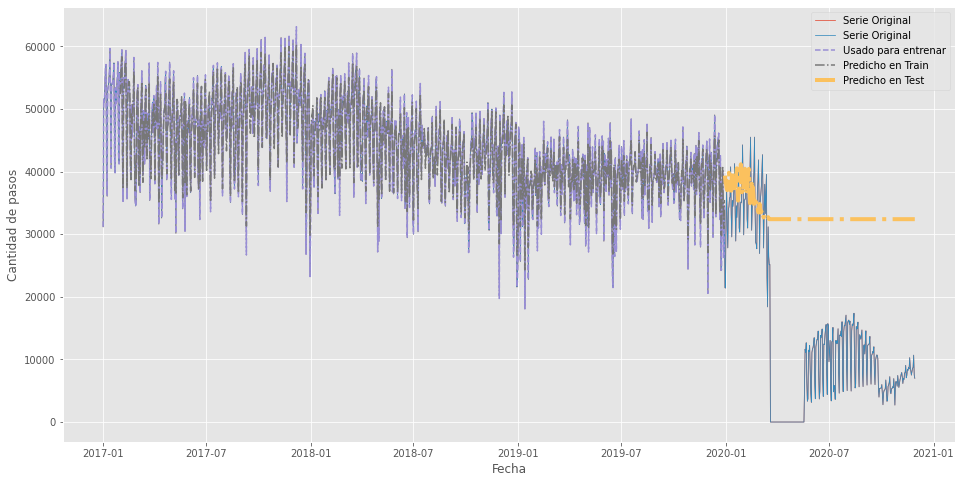

In [211]:
plt.figure(figsize=(16,8))

plt.plot(diariografico.fecha[:length_total], diariografico.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diariografico.fecha[:length_total], diariografico.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diariografico.fecha[:N_train + look_back], diariografico.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diariografico.fecha[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diariografico.fecha[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()

Obviamente se observa una mejor predicción utilizando el modelo Propget que el modelo lineal, igualmente esperaba que sea mas preciso y no sólo un poco más preciso. 
Todo esto teniendo en cuenta, como ya se dijo anteriormente, que ningun modelo puede predecir con datos anteriores una pandemia global, si sólo analizamos el primer trimestre, sigue siendo baja la predicción.

Creo que ni el modelo creado ni ningun otro podría servir en estos casos, a menos que se tenga información de antemano y se pueda agregar al análisis.

La única opción de conseguir un buen modelo (quitando la pandemia del medio) sería agregar más información, como por ejemplo, tener en cuenta los otros medios de pago, homeoffice, tipos de vehículos más detallados, etc.

En otro proyecto ( que no descarto hacerlo en el 4to) se debería arrancar con información pre pandemia (2018 y 2019) y años post pandemia (año 2020 y 2021) para intentar predecir el crecimiento a futuro en la circulación (2022), intentando predecir la rapidez con la que se volverá a estándares normales y si aumentará o disminuirá. 

Obviamente, dicho análisis estará afectado por variables económicas que conocemos actualmente.